<a href="https://colab.research.google.com/github/cristinakuo/thesis-pre-research/blob/master/BRNN_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Montaje de Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import tqdm

print(torch.cuda.is_available())

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

device = torch.device(dev)  

True


## Carga de datos: Coeficientes cepstrum con 10 ventanas de contexto

# Lectura de los archivos out_lab_fea_xx.pkl

 - Cada archivo contiene los datos de train, dev y test.
 - Se asume que dichos archivos se encuentran en un directorio llamado data en el directorio de ejecución
 - Los datos que contiene cada archivo (supongamos que sea el archivo con datos de train) son:
     - `data_name_train` Contiene el nombre del archivo de TIMIT que corresponde a cada frase
     - `data_set_train` Es un array de numpy. Cada fila contiene los coeficientes de un frame de una frase y de los cw_l y cw_r anteriores y posteriores al frame actual. Además la última columna contiene la etiqueta con el número de fonema de los 61 fonemas posibles al que corresponde (0-60). Para distinguir a que frase corresponde cada frame se usa `data_end_index_train`.
     - `data_end_index_train` Es un vector de numpy que indica la fila de `data_set_train` que corresponde al primer frame de la siguiente frase (eg. si fuera `data_end_index_train = [308,650...]` significaría que la primera frase se encuentra entre las filas 0 y 307 de la `matriz data_set_train` y la segunda entre la 308 y la 649. 
     - `fea_dict_train`. Es un diccionario que se usa para pasar información al kaldi. De acá el ancho de las ventanas de contexto `cw_l = fea_dict_train['mfcc'][3]` y `cw_r = fea_dict_train['mfcc'][4]`. También contiene el tamaño de las features y si hubiera mas features además de mfcc serían otras keys del diccionario.
     - `lab_dict_train`. No se usa de momento
     - `todo_train`. Vale `train`, `test`, o `dev` 


In [3]:
# Load files: out_lab_fea_xx.pkl
# Saves the dictionary total_set in 3 files 
# that should contain train, dev and test data (in any order)

import pickle
import numpy as np

# Directorio de salida
tipo = ''
out_folder = '/content/gdrive/My Drive/Tesis/data/'
xi = 3 # Esto indica el nombre de los tres archivos (train, dev y test) 
xf = 6

total_set = dict()
for i in range(xi,xf):
    idf = str(i)
    out_file = 'out_lab_fea_' + idf + '.pkl'

    with open(out_folder+out_file,'rb') as f:
        total = pickle.load(f)
    total_set[total[5]] = total
    
data_name_train = total_set['train'][0]
data_end_index_train = total_set['train'][1]
fea_dict_train = total_set['train'][2]
lab_dict_train = total_set['train'][3]
data_set_train = total_set['train'][4]
todo_train = total_set['train'][5]

data_name_dev = total_set['dev'][0]
data_end_index_dev = total_set['dev'][1]
fea_dict_dev = total_set['dev'][2]
lab_dict_dev = total_set['dev'][3]
data_set_dev = total_set['dev'][4]
todo_dev = total_set['dev'][5]

data_name_test = total_set['test'][0]
data_end_index_test = total_set['test'][1]
fea_dict_test = total_set['test'][2]
lab_dict_test = total_set['test'][3]
data_set_test = total_set['test'][4]
todo_test = total_set['test'][5]

## Ordenar los datos

In [4]:
nr_phrases_train = len(data_name_train)
nr_phrases_test = len(data_name_test)

print('Nr of phrases (train): ', nr_phrases_train)
print('Nr of phrases (test): ', nr_phrases_test)

data_set_train_phrases = np.split(data_set_train, data_end_index_train)[:-1] # Last item is empty
data_set_test_phrases = np.split(data_set_test, data_end_index_test)[:-1]

print('Train: split data into {} phrases.'.format(len(data_set_train_phrases)))
print('Test: split data into {} phrases.'.format(len(data_set_test_phrases)))

Nr of phrases (train):  3696
Nr of phrases (test):  192
Train: split data into 3696 phrases.
Test: split data into 192 phrases.


In [5]:
num_coef = 13

# Divide data into input (x) y output (y)
x_train = [data_set_train[:,:-1] for data_set_train in data_set_train_phrases]
y_train = [data_set_train[:,-1].transpose() for data_set_train in data_set_train_phrases]
x_test = [data_set_test[:,:-1] for data_set_test in data_set_test_phrases]
y_test = [data_set_test[:,-1].transpose() for data_set_test in data_set_test_phrases]

# Add batch dimension to inputs
x_train = [x.reshape((1, -1, num_coef )) for x in x_train]
x_test = [x.reshape(1, -1, num_coef) for x in x_test]

print('x_train shape: ', x_train[0].shape)
print('x_test shape: ', x_test[0].shape)

# Transform to tensor
x_train = [torch.from_numpy(phrase).requires_grad_().type(torch.FloatTensor) for phrase in x_train]
y_train = [torch.from_numpy(phrase).type(torch.LongTensor) for phrase in y_train]
x_test = [torch.from_numpy(phrase).requires_grad_().type(torch.FloatTensor) for phrase in x_test]
y_test = [torch.from_numpy(phrase).type(torch.LongTensor) for phrase in y_test]

print('x_train shape: ', x_train[0].shape)
print('x_test shape: ', x_test[0].shape)

# Save in Device
x_train = [phrase.to(device) for phrase in x_train]
y_train = [phrase.to(device) for phrase in y_train]
x_test = [phrase.to(device) for phrase in x_test]
y_test = [phrase.to(device) for phrase in y_test]

# Get size of tran and test set
train_size = len(x_train)
test_size = len(x_test)

print("--Train data")
print("Number of samples: ", train_size)

print("--Test data")
print("Number of samples: ", test_size)

x_train shape:  (1, 90, 13)
x_test shape:  (1, 129, 13)
x_train shape:  torch.Size([1, 90, 13])
x_test shape:  torch.Size([1, 129, 13])
--Train data
Number of samples:  3696
--Test data
Number of samples:  192


In [6]:
print(x_test[0].shape)

torch.Size([1, 129, 13])


## Definir la clase MLP

In [7]:
class BRNN(nn.Module):
  def __init__(self, input_size, hidden_size, nr_layers, output_size):
    super(BRNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.nr_layers = nr_layers # Recurrent layers

    # Hidden layer
    self.rnn = nn.RNN(self.input_size, self.hidden_size, self.nr_layers, batch_first=True, bidirectional=True, bias=True)
    
    # Output Layer
    self.fc = torch.nn.Linear(self.hidden_size*2, self.output_size, bias=True)

  def forward(self, x, hidden=None):
    batch_size = x.shape[0]

    if hidden is None:
      hidden = self.init_hidden(x)
    # Set initial states
    #h0 = torch.zeros(self.nr_layers*2, x.size(0), self.hidden_size).requires_grad_().to(device)
    
    out, hidden = self.rnn(x, hidden)
    #print('OUT of rnn IS: ', out.shape) # It has 370 outputs due to hidden units
    #print('hidden of rnn IS: ', out.shape)
    out = self.fc(out.squeeze(0)) # Decode the hidden state of the last time step # TODO: is this okay, maybe I should use last t
    #print('OUT of rnn linear IS: ', out.shape)
    #print(out)
    return out, hidden

  def init_hidden(self,x):
    # TODO: is this dimension okay?? maybe the size(0) should be in the first position
    return torch.zeros(self.nr_layers*2, x.size(0), self.hidden_size).requires_grad_().to(device)

## Instanciar un modelo BRNN

In [8]:
NR_PHONEMES = 61
input_size = num_coef # Number of coefficients
hidden_size = 185 # Specified by Graves
output_size = NR_PHONEMES # Number of phonemes
layer_size = 2 # Two hidden layers


print("Creating MLP model with parameters:")
print("Input size: ", input_size)
print("Hidden size: ", hidden_size)
print("Layer size: ", layer_size)
print("Output size: ", output_size)

model = BRNN(input_size, hidden_size, layer_size, output_size)
model = model.to(device)

Creating MLP model with parameters:
Input size:  13
Hidden size:  185
Layer size:  2
Output size:  61


In [9]:
learning_rate = 10e-5 # Specified by Graves
momentum = 0.9

cost_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

Ver Loss antes de entrenar

In [10]:
# See the loss before training
model.eval()

total_loss = 0
nr_correct_frames = 0
nr_total_frames = 0

hidden = None
for (x_test_phrase, y_test_phrase) in zip(x_test, y_test):
  #x_test_phrase = x_test_phrase.reshape(-1, x_test_phrase.size(0), input_size)
  #x_test_phrase = x_test_phrase.to(device)
  #print(x_test_phrase.shape)
  output_test, _ = model(x_test_phrase, hidden)
  #print('y pred: ', output_test.shape)
  #print('y_test: ', y_test_phrase.shape)
  total_loss += cost_function(output_test, y_test_phrase)

  # TODO: quizas usando squeeze y unsqueeze
  # Correct samples
  y_prediction_test = torch.argmax(output_test, dim=1)
  nr_correct_frames += int((y_prediction_test == y_test_phrase).sum())
  nr_total_frames += len(y_test_phrase)

before_train_loss = total_loss/test_size
print('Before train Loss:', before_train_loss.item())

perc_correct = nr_correct_frames/nr_total_frames*100
print("Correct frames percentage: ", perc_correct)


Before train Loss: 4.1221418380737305
Correct frames percentage:  1.3760596695384935


### Training time

In [11]:
import time
torch.autograd.set_detect_anomaly(True)

nr_epochs = 20
epoch_losses_train = []
epoch_losses_test = []
epoch_correct_frames_train = []
epoch_correct_frames_test = []

start_time = time.time()
# TODO: initial weights? Graves: from flat distribution between -0.1 and 0.1
for epoch in range(nr_epochs):
  print(f'EPOCH #{epoch+1}')
  #=========Train ==============#
  model.train()
  hidden = None
  # Variables used to get the percentage of correct frames
  nr_correct_frames = 0
  nr_total_frames = 0

  epoch_total_loss = 0

  # Randomize the order of phrases for each epoch
  random_idxs = np.random.permutation(train_size)
  
  for i in tqdm.notebook.tqdm(random_idxs):
    print(x_train[i].shape)
    # Forward pass
    y_pred, hidden = model(x_train[i], hidden)
    
    # Compute loss
    loss = cost_function(y_pred, y_train[i])
    epoch_total_loss += loss.item()

    # Get number of Correct franmes
    y_pred_labels = torch.argmax(y_pred, dim=1)
    nr_correct_frames += int((y_pred_labels == y_train[i]).sum())
    nr_total_frames += len(y_train[i])

    # Backward pass
    optimizer.zero_grad() # Clear grads before doing backward
    loss.backward(retain_graph=True)
    optimizer.step()
  
  # Epoch training results
  epoch_loss_train = epoch_total_loss/train_size
  perc_correct_train = nr_correct_frames/nr_total_frames*100
  print(f'Train loss: {epoch_loss}')
  print("Correct frames percentage: ", perc_correct_train)

  # =====See test results========#
  model.eval()
  print('Test results: ')
  nr_correct_test = 0
  nr_total_test = 0

  epoch_total_loss_test = 0

  for (x_test_phrase, y_test_phrase) in zip(x_test, y_test):
    output_test = model(x_test_phrase)
    after_train_loss = cost_function(output_test, y_test_phrase)
    epoch_total_loss += after_train_loss.item()
    # Correct frames
    y_prediction_test = torch.argmax(output_test, dim=1)
    nr_correct_test += int((y_prediction_test == y_test_phrase).sum())
    nr_total_test += len(y_test_phrase)

  perc_correct_test = nr_correct_test/nr_total_test*100
  epoch_loss_test = epoch_total_loss/test_size
  print("Percentage of Correct: ", perc_correct_test)
  print("After train loss: ", after_train_loss.item())

  # Append epoch results 
  epoch_losses_train.append(epoch_loss_train)
  epoch_losses_test.append(epoch_loss_test)
  epoch_correct_frames_train.append(perc_correct_train)
  epoch_correct_frames_test.append(perc_correct_test)

  print()


print('Done training')
print()
end_time = time.time()

duration = end_time - start_time

print(f'Total training time: {duration} seconds')

# Save model
import pandas as pd
from datetime import date

epoch_info = pd.DataFrame({'loss_train': epoch_losses_train, 'loss_test': epoch_losses_test, 'correct_frames_train': epoch_correct_frames_train, 'correct_frames_test': epoch_correct_frames_test, 'trainig_duration': duration})

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/BRNN/'
date_of_training = str(date.today())
filename = date_of_training + '_' + str(nr_epochs) + 'epochs' + suffix

model_filepath = root_path + 'model_' + filename + '.pt'
epoch_info_filepath = root_path + 'epoch_info_' + filename + '.csv'

torch.save(model, model_filepath)
epoch_info.to_csv(epoch_info_filepath)

EPOCH #1


torch.Size([1, 242, 13])
torch.Size([1, 317, 13])



RuntimeError: ignored

### See Loss after training

In [ ]:
# Save model
import pandas as pd
from datetime import date

epoch_info = pd.DataFrame({'loss_train': epoch_losses_train, 'loss_test': epoch_losses_test, 'correct_frames_train': epoch_correct_frames_train, 'correct_frames_test': epoch_correct_frames_test, 'training_duration': duration})

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/'
date_of_training = str(date.today())
filename = date_of_training + '_' + str(nr_epochs) + 'epochs' + suffix

model_filepath = root_path + 'model_' + filename + '.pt'
epoch_info_filepath = root_path + 'epoch_info_' + filename + '.csv'

torch.save(model, model_filepath)
epoch_info.to_csv(epoch_info_filepath)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MultiLayerPerceptron. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
# Load model
model = torch.load(model_filepath, map_location=device)
epoch_info = pd.read_csv(epoch_info_filepath)

In [ ]:
# See the loss After training
model.eval()

nr_correct = 0
nr_total = 0
for (x_test_phrase, y_test_phrase) in zip(x_test, y_test):
  output_test = model(x_test_phrase)
  after_train_loss = cost_function(output_test, y_test_phrase)
  
  # Correct samples
  y_prediction_test = torch.argmax(output_test, dim=1)
  nr_correct += int((y_prediction_test == y_test_phrase).sum())
  nr_total += len(y_test_phrase)

perc_correct = nr_correct/nr_total*100
print("Percentage of Correct: ", perc_correct)
print("After train loss: ", after_train_loss.item())

Percentage of Correct:  44.479179260436275
After train loss:  1.761474609375


## Plots

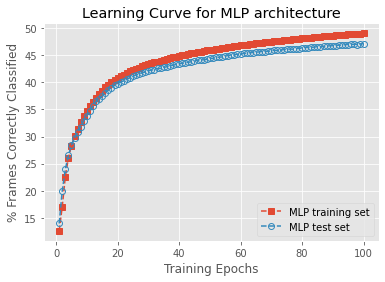

Training time:  532.2373199462891


In [ ]:
# Learning Curve

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots()
epochs = np.arange(1,nr_epochs+1)
ax.plot(epochs, epoch_info['correct_frames_train'], '--s', label='MLP training set')
ax.plot(epochs, epoch_info['correct_frames_test'], '--o', markerfacecolor='None', label='MLP test set')

training_time = epoch_info['trainig_duration'][0]
ax.set(xlabel='Training Epochs', ylabel='% Frames Correctly Classified',
       title='Learning Curve for MLP architecture')

learning_curve_filepath = root_path +'learning_curve_' + filename + '.png'
plt.legend()
fig.savefig(learning_curve_filepath)
plt.show()

